In [1]:
from lib import data as dat
from lib import handler
from lib import model_methods
import datetime

import logging
logging.getLogger('tensorflow').disabled = True     # Disable Tensorflow warning messages.

import yfinance as yf
import os
import datetime as dt
import shutil
import pandas as pd
import numpy as np

# Define current directory and Database subdirectory.

In [2]:
cwd = os.getcwd()
directory = handler.directories(d = cwd)
db_subdir = directory.location('Data') # Find Database subdirectory location.

# Data Acquisition from Yahoo Finance

In [3]:
crypto_list = ['XRP-USD', 'BTC-USD', 'ETH-USD', 'ADA-USD', 'TRX-USD']    # Cryptocurrency list.
start_date = dt.datetime(2019, 11, 1) # Apporximate pandemic start date.

cryptos = dat.data(start = start_date)    # Initiate crypto class.
cryptos.crypto(database = 'Pandemic_Cryptos.db', crypt = crypto_list, today = True) # Get crypto data from Yahoo API.

db_output = directory.contents(dir = cwd, pattern = 'Pandemic_C', extension = '.db') # Find database output.
filename = os.path.basename(db_output)
slash = directory.OS()  # Operating system.
shutil.move(db_output, db_subdir + slash + filename)    # Move database output to Databases subdirectory.
db_path = directory.contents(dir = db_subdir, pattern = 'Pandemic_C', extension = '.db') # Find the new locations of the database.

Connecting to Yahoo Finance...
Fetching XRP-USD cryptocurrency data...
[*********************100%***********************]  1 of 1 completed
Adding XRP-USD data to Pandemic_Cryptos.db database...
XRP-USD cryptocurrency data saved!

Fetching BTC-USD cryptocurrency data...
[*********************100%***********************]  1 of 1 completed
Adding BTC-USD data to Pandemic_Cryptos.db database...
BTC-USD cryptocurrency data saved!

Fetching ETH-USD cryptocurrency data...
[*********************100%***********************]  1 of 1 completed
Adding ETH-USD data to Pandemic_Cryptos.db database...
ETH-USD cryptocurrency data saved!

Fetching ADA-USD cryptocurrency data...
[*********************100%***********************]  1 of 1 completed
Adding ADA-USD data to Pandemic_Cryptos.db database...
ADA-USD cryptocurrency data saved!

Fetching TRX-USD cryptocurrency data...
[*********************100%***********************]  1 of 1 completed
Adding TRX-USD data to Pandemic_Cryptos.db database...
TRX-U

# SQLite Queries

In [4]:
# Data Query. All SQL tables are added into individual pandas dataframes.
crypto_list_temp = ['XRP_USD', 'BTC_USD', 'ETH_USD', 'ADA_USD', 'TRX_USD'] # Temporary list holds the names of the tables for each cryptocurrency.

xrp = dat.SQLite_Query(db_path, crypto_list_temp[0]) 
btc = dat.SQLite_Query(db_path, crypto_list_temp[1])
eth = dat.SQLite_Query(db_path, crypto_list_temp[2])
ada = dat.SQLite_Query(db_path, crypto_list_temp[3])
trx = dat.SQLite_Query(db_path, crypto_list_temp[4])

# Data Preprocessing

In [5]:
pred_days = 365 # number of days used for prediction.

xrp_preprocessing = model_methods.preprocessing(xrp, pred_days)
btc_preprocessing = model_methods.preprocessing(btc, pred_days) 
eth_preprocessing = model_methods.preprocessing(eth, pred_days) 
ada_preprocessing = model_methods.preprocessing(ada, pred_days) 
trx_preprocessing = model_methods.preprocessing(trx, pred_days) 

percentage_vol = lambda x : round(x, 4) * 100 # Lambda function to calculate volatility.  

# Ripple

Training the model...
[*********************100%***********************]  1 of 1 completed


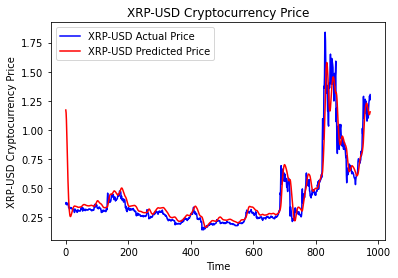

XRP-USD Cryptocurrency Adj.Close price prediction for 2021-09-06: $1.170520
XRP-USD Cryptocurrency Volatility = 112.44000000000001%


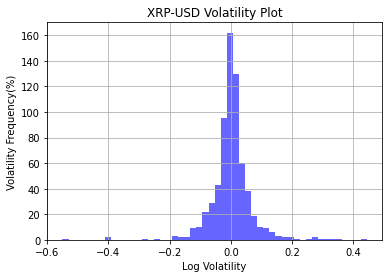

In [6]:
xrp_x_train = xrp_preprocessing[0]
xrp_y_train = xrp_preprocessing[1]
xrp_scaler = xrp_preprocessing[2]

# Training starts.
print('Training the model...')
XRP_model = model_methods.CNN_model(xrp_x_train, xrp_y_train, 50, 1, 'adam', 'mean_squared_error', 25, 32)

# Test data.
test_start = dt.datetime(2019, 1, 1)
test_end = datetime.datetime.now().date().isoformat()   # Today.
xrp_test_data = yf.download(tickers = crypto_list[0], start = test_start, end = test_end) # Get test data from Yahoo.
xrp_actual_prices = xrp_test_data['Close'].values   # Get closing cryptocurrency prices.

xrp_dataset = pd.concat((xrp['Close'], xrp_test_data['Close']), axis = 0)
xrp_model_inputs = xrp_dataset[len(xrp_dataset) - len(xrp_test_data) - pred_days:].values
xrp_model_inputs = xrp_model_inputs.reshape(-1, 1)
xrp_model_inputs = xrp_scaler.transform(xrp_model_inputs) # Data scaled according to the scaler.

# Make predictions on test data.
xrp_x_test = model_methods.test_preprocessing(pred_days, xrp_model_inputs)
xrp_pred_prices = XRP_model.predict(xrp_x_test, verbose = 0)
xrp_pred_prices = xrp_scaler.inverse_transform(xrp_pred_prices)

# Plot Results
model_methods.plot_data(name = crypto_list[0], type = 'Cryptocurrency', actual = xrp_actual_prices, predicted = xrp_pred_prices, colour_actual = "blue", colour_predicted = "red")

# Predict next day
model_methods.next_day_prediction(input = xrp_model_inputs, name = crypto_list[0], type = 'Cryptocurrency', prediction_days = pred_days, model = XRP_model, scaler = xrp_scaler)

# Volatility
xrp_copy = xrp.copy()   # Copy of dataframe to add a new column for volatility.
xrp_copy['Log returns'] = np.log(xrp['Close']/xrp['Close'].shift())   # Creates a column called 'Log returns' with the daily log return of the Close price.
xrp_returns = xrp_copy['Log returns']
xrp_returns.std()
xrp_volatility = xrp_returns.std()*252**.5   # 255 is the trading days per annum. **.5 is square root.
volat = str(percentage_vol(xrp_volatility))
model_methods.plot_volatility(xrp_copy['Log returns'], volat, name = crypto_list[0])
print('%s Cryptocurrency Volatility = %s%%' %(crypto_list[0], volat))

# Bitcoin

Training the model...
[*********************100%***********************]  1 of 1 completed


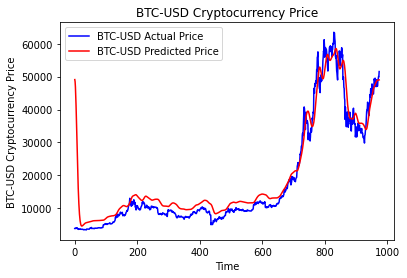

BTC-USD Cryptocurrency Adj.Close price prediction for 2021-09-06: $49105.421875
BTC-USD Cryptocurrency Volatility = 64.95%


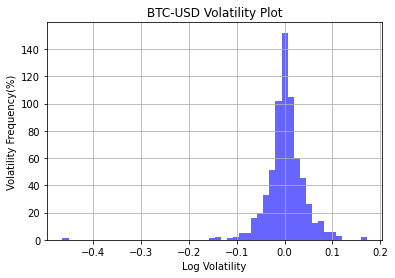

In [7]:
btc_x_train = btc_preprocessing[0]
btc_y_train = btc_preprocessing[1]
btc_scaler = btc_preprocessing[2]

# Training starts.
print('Training the model...')
BTC_model = model_methods.CNN_model(btc_x_train, btc_y_train, 50, 1, 'adam', 'mean_squared_error', 25, 32)

# Test data.
test_start = dt.datetime(2019, 1, 1)
test_end = datetime.datetime.now().date().isoformat()   # Today.
btc_test_data = yf.download(tickers = crypto_list[1], start = test_start, end = test_end) # Get test data from Yahoo.
btc_actual_prices = btc_test_data['Close'].values # Get closing cryptocurrency prices.

btc_dataset = pd.concat((btc['Close'], btc_test_data['Close']), axis = 0)
btc_model_inputs = btc_dataset[len(btc_dataset) - len(btc_test_data) - pred_days:].values
btc_model_inputs = btc_model_inputs.reshape(-1, 1)
btc_model_inputs = btc_scaler.transform(btc_model_inputs) # Data scaled according to the scaler.

# Make predictions on test data.
btc_x_test = model_methods.test_preprocessing(pred_days, btc_model_inputs)
btc_pred_prices = BTC_model.predict(btc_x_test, verbose = 0)
btc_pred_prices = btc_scaler.inverse_transform(btc_pred_prices)

# Plot Results
model_methods.plot_data(name = crypto_list[1], type = 'Cryptocurrency', actual = btc_actual_prices, predicted = btc_pred_prices, colour_actual = "blue", colour_predicted = "red")

# Predict next day
model_methods.next_day_prediction(input = btc_model_inputs, name = crypto_list[1], type = 'Cryptocurrency', prediction_days = pred_days, model = BTC_model, scaler = btc_scaler)

# Volatility
btc_copy = btc.copy()   # Copy of dataframe to add a new column for volatility.
btc_copy['Log returns'] = np.log(btc['Close']/btc['Close'].shift())   # Creates a column called 'Log returns' with the daily log return of the Close price.
btc_returns = btc_copy['Log returns']
btc_returns.std()
btc_volatility = btc_returns.std()*252**.5 # 255 is the trading days per annum.
volat = str(percentage_vol(btc_volatility))
model_methods.plot_volatility(btc_returns, volat, name = crypto_list[1])
print('%s Cryptocurrency Volatility = %s%%' %(crypto_list[1], volat))

# Ethereum

Training the model...
[*********************100%***********************]  1 of 1 completed


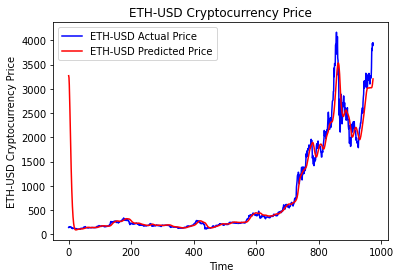

ETH-USD Cryptocurrency Adj.Close price prediction for 2021-09-06: $3271.653564
ETH-USD Cryptocurrency Volatility = 86.76%


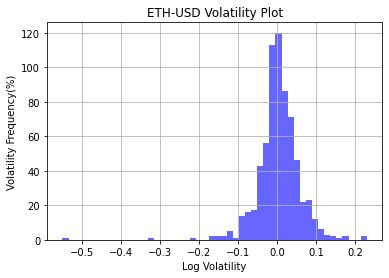

In [8]:
eth_x_train = eth_preprocessing[0]
eth_y_train = eth_preprocessing[1]
eth_scaler = eth_preprocessing[2]

# Training starts.
print('Training the model...')
ETH_model = model_methods.CNN_model(eth_x_train, eth_y_train, 50, 1, 'adam', 'mean_squared_error', 25, 32)

# Test data.
test_start = dt.datetime(2019, 1, 1)
test_end = datetime.datetime.now().date().isoformat()   # Today.
eth_test_data = yf.download(tickers = crypto_list[2], start = test_start, end = test_end) # Get test data from Yahoo.
eth_actual_prices = eth_test_data['Close'].values # Get closing Cryptocurrency prices.

eth_dataset = pd.concat((eth['Close'], eth_test_data['Close']), axis = 0)
eth_model_inputs = eth_dataset[len(eth_dataset) - len(eth_test_data) - pred_days:].values
eth_model_inputs = eth_model_inputs.reshape(-1, 1)
eth_model_inputs = eth_scaler.transform(eth_model_inputs) # Data scaled according to the scaler.

# Make predictions on test data.
eth_x_test = model_methods.test_preprocessing(pred_days, eth_model_inputs)
eth_pred_prices = ETH_model.predict(eth_x_test, verbose = 0)
eth_pred_prices = eth_scaler.inverse_transform(eth_pred_prices)

# Plot Results
model_methods.plot_data(name = crypto_list[2], type = 'Cryptocurrency', actual = eth_actual_prices, predicted = eth_pred_prices, colour_actual = "blue", colour_predicted = "red")

# Predict next day
model_methods.next_day_prediction(input = eth_model_inputs, name = crypto_list[2], type = 'Cryptocurrency', prediction_days = pred_days, model = ETH_model, scaler = eth_scaler)

# Volatility
eth_copy = eth.copy()   # Copy of dataframe to add a new column for volatility.
eth_copy['Log returns'] = np.log(eth['Close']/eth['Close'].shift())   # Creates a column called 'Log returns' with the daily log return of the Close price.
eth_returns = eth_copy['Log returns']
eth_returns.std()
eth_volatility = eth_returns.std()*252**.5 # 255 is the trading days per annum.
volat = str(percentage_vol(eth_volatility))
model_methods.plot_volatility(eth_copy['Log returns'], volat, name = crypto_list[2])
print('%s Cryptocurrency Volatility = %s%%' %(crypto_list[2], volat))

# Cardano

Training the model...
[*********************100%***********************]  1 of 1 completed


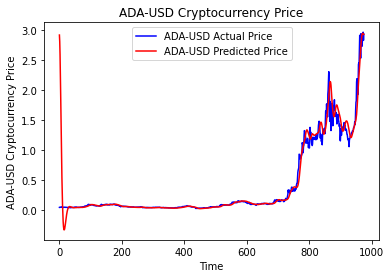

ADA-USD Cryptocurrency Adj.Close price prediction for 2021-09-06: $2.921496
ADA-USD Cryptocurrency Volatility = 101.15%


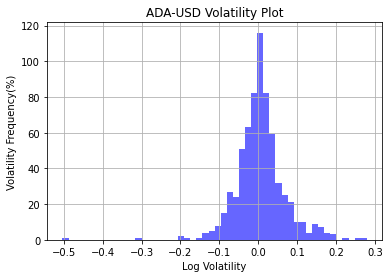

In [9]:
ada_x_train = ada_preprocessing[0]
ada_y_train = ada_preprocessing[1]
ada_scaler = ada_preprocessing[2]

# Training starts.
print('Training the model...')
ADA_model = model_methods.CNN_model(ada_x_train, ada_y_train, 50, 1, 'adam', 'mean_squared_error', 25, 32)

# Test data.
test_start = dt.datetime(2019, 1, 1)
test_end = datetime.datetime.now().date().isoformat()   # Today.
ada_test_data = yf.download(tickers = crypto_list[3], start = test_start, end = test_end) # Get test data from Yahoo.
ada_actual_prices = ada_test_data['Close'].values # Get closing cryptocurrency prices.

ada_dataset = pd.concat((ada['Close'], ada_test_data['Close']), axis = 0)
ada_model_inputs = ada_dataset[len(ada_dataset) - len(ada_test_data) - pred_days:].values
ada_model_inputs = ada_model_inputs.reshape(-1, 1)
ada_model_inputs = ada_scaler.transform(ada_model_inputs) # Data scaled according to the scaler.

# Make predictions on test data.
ada_x_test = model_methods.test_preprocessing(pred_days, ada_model_inputs)
ada_pred_prices = ADA_model.predict(ada_x_test, verbose = 0)
ada_pred_prices = ada_scaler.inverse_transform(ada_pred_prices)

# Plot Results
model_methods.plot_data(name = crypto_list[3], type = 'Cryptocurrency', actual = ada_actual_prices, predicted = ada_pred_prices, colour_actual = "blue", colour_predicted = "red")

# Predict next day
model_methods.next_day_prediction(input = ada_model_inputs, name = crypto_list[3], type = 'Cryptocurrency', prediction_days = pred_days, model = ADA_model, scaler = ada_scaler)

# Volatility
ada_copy = ada.copy()   # Copy of dataframe to add a new column for volatility.
ada_copy['Log returns'] = np.log(ada['Close']/ada['Close'].shift())   # Creates a column called 'Log returns' with the daily log return of the Close price.
ada_returns = ada_copy['Log returns']
ada_returns.std()
ada_volatility = ada_returns.std()*252**.5 # 255 is the trading days per annum.
volat = str(percentage_vol(ada_volatility))
model_methods.plot_volatility(ada_copy['Log returns'], volat, name = crypto_list[3])
print('%s Cryptocurrency Volatility = %s%%' %(crypto_list[3], volat))

# Tron

Training the model...
[*********************100%***********************]  1 of 1 completed


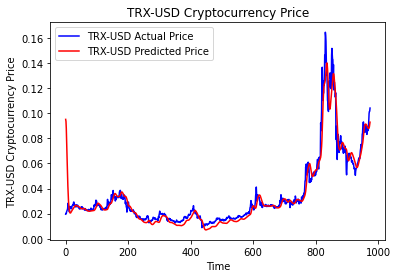

TRX-USD Cryptocurrency Adj.Close price prediction for 2021-09-06: $0.095149
TRX-USD Cryptocurrency Volatility = 96.22%


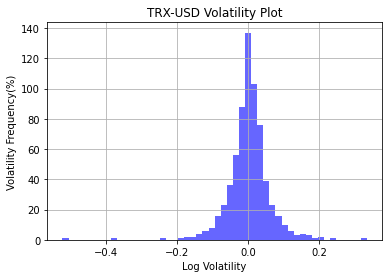

In [10]:
trx_x_train = trx_preprocessing[0]
trx_y_train = trx_preprocessing[1]
trx_scaler = trx_preprocessing[2]

# Training starts.
print('Training the model...')
TRX_model = model_methods.CNN_model(trx_x_train, trx_y_train, 50, 1, 'adam', 'mean_squared_error', 25, 32)

# Test data.
test_start = dt.datetime(2019, 1, 1)
test_end = datetime.datetime.now().date().isoformat()   # Today.
trx_test_data = yf.download(tickers = crypto_list[4], start = test_start, end = test_end) # Get test data from Yahoo.
trx_actual_prices = trx_test_data['Close'].values # Get closing cryptocurrency prices.

trx_dataset = pd.concat((trx['Close'], trx_test_data['Close']), axis = 0)
trx_model_inputs = trx_dataset[len(trx_dataset) - len(trx_test_data) - pred_days:].values
trx_model_inputs = trx_model_inputs.reshape(-1, 1)
trx_model_inputs = trx_scaler.transform(trx_model_inputs) # Data scaled according to the scaler.

# Make predictions on test data.
trx_x_test = model_methods.test_preprocessing(pred_days, trx_model_inputs)
trx_pred_prices = TRX_model.predict(trx_x_test, verbose = 0)
trx_pred_prices = trx_scaler.inverse_transform(trx_pred_prices)

# Plot Results
model_methods.plot_data(name = crypto_list[4], type = 'Cryptocurrency', actual = trx_actual_prices, predicted = trx_pred_prices, colour_actual = "blue", colour_predicted = "red")

# Predict next day
model_methods.next_day_prediction(input = trx_model_inputs, name = crypto_list[4], type = 'Cryptocurrency', prediction_days = pred_days, model = TRX_model, scaler = trx_scaler)

# Volatility
trx_copy = trx.copy()   # Copy of dataframe to add a new column for volatility.
trx_copy['Log returns'] = np.log(trx['Close']/trx['Close'].shift())   # Creates a column called 'Log returns' with the daily log return of the Close price.
trx_returns = trx_copy['Log returns']
trx_returns.std()
trx_volatility = trx_returns.std()*252**.5 # 255 is the trading days per annum.
volat = str(percentage_vol(trx_volatility))
model_methods.plot_volatility(trx_copy['Log returns'], volat, name = crypto_list[4])
print('%s Cryptocurrency Volatility = %s%%' %(crypto_list[4], volat))